### Bayesian data analysis
##  Chapter 10, demo 1

Rejection sampling example

In rejection sampling the proposal distribution $g(\theta)$ has to form an envelope over the target distribution $q(\theta)$, that is, there has to be value $M$ so that
\begin{equation*}
  \frac{q(\theta)}{M g(\theta)} \leq 1.
\end{equation*}


In [7]:
import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [8]:
import os, sys
# add utilities directory to path
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import plot_tools

In [9]:
# edit default plot settings
plt.rc('font', size=12)

In [10]:
# fake interesting distribution
x = np.linspace(-3, 3, 200)
r = np.array([ 1.1 ,  1.3 , -0.1 , -0.7 ,  0.2 , -0.4 ,  0.06, -1.7 ,
               1.7 ,  0.3 ,  0.7 ,  1.6 , -2.06, -0.74,  0.2 ,  0.5 ])
# Estimate the density (named q, to emphesize that it does not need to be
# normalized). Parameter bw_method=0.48 is used to mimic the outcome of the
# kernelp function in Matlab.
q = stats.gaussian_kde(r, bw_method=0.48).evaluate(x)

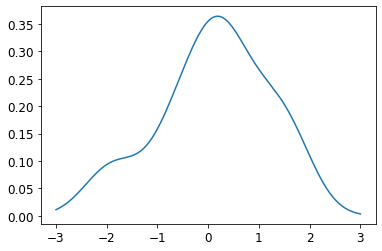

In [16]:
plt.plot(x, q)

In [17]:
# rejection sampling example
g_mean = 0
g_std = 1.1
g = stats.norm.pdf(x, loc=g_mean, scale=g_std)
# M is computed by discrete approximation
M = np.max(q/g)
# prescale
g *= M

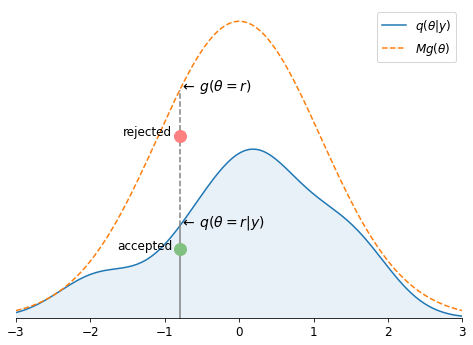

In [18]:
# plot the densities
plt.figure(figsize=(8, 6))
plot_tools.modify_axes.only_x(plt.gca())
plt.plot(x, q)
plt.plot(x, g, linestyle='--')
plt.xlim([x[0], x[-1]])
plt.fill_between(x, q, color=plot_tools.lighten('C0', 0.9))
plt.legend((r'$q(\theta|y)$', r'$Mg(\theta)$'))

# illustrate one sample
r1 = -0.8
zi = np.argmin(np.abs(x-r1)) # find the closest grid point
plt.plot((x[zi], x[zi]), (0, q[zi]), color='gray')
plt.plot((x[zi], x[zi]), (q[zi], g[zi]), color='gray', linestyle='--')
r21 = 0.3 * g[zi]
r22 = 0.8 * g[zi]
plt.plot(r1, r21, marker='o', color=plot_tools.lighten('green'), markersize=12)
plt.plot(r1, r22, marker='o', color=plot_tools.lighten('red'), markersize=12)
# add annotations
plt.text(x[zi], q[zi], r'$\leftarrow \, q(\theta=r|y)$', fontsize=14)
plt.text(x[zi], g[zi], r'$\leftarrow \, g(\theta=r)$', fontsize=14)
plt.text(r1-0.1, r21, 'accepted', ha='right')
plt.text(r1-0.1, r22, 'rejected', ha='right');

In [19]:
# get nsamp samples
nsamp = 200
r1 = stats.norm.rvs(size=nsamp, loc=g_mean, scale=g_std)
zi = np.argmin(np.abs(x[:,None] - r1), axis=0)
r2 = np.random.rand(nsamp) * g[zi]
acc = r2 < q[zi]

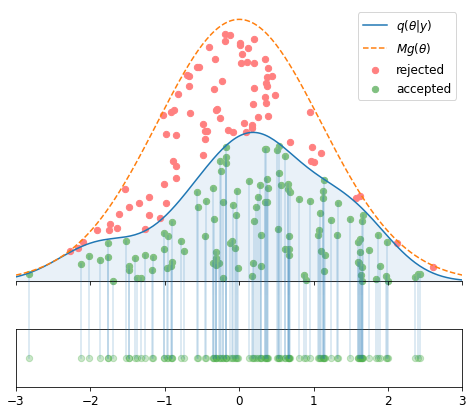

In [20]:
# plot the densities againg
fig, axes = plt.subplots(
    2, 1,
    figsize=(8, 7),
    sharex=True,
    gridspec_kw=dict(
        height_ratios=[5, 1]
    ),
)

ax = axes[0]
plot_tools.modify_axes.only_x(ax)
ax.plot(x, q, label=r'$q(\theta|y)$')
ax.plot(x, g, linestyle='--', label=r'$Mg(\theta)$')
ax.fill_between(x, q, color=plot_tools.lighten('C0', 0.9))
# the samples
ax.scatter(
    r1[~acc],
    r2[~acc],
    40,
    color=plot_tools.lighten('red'),
    label='rejected'
)
ax.scatter(
    r1[acc],
    r2[acc],
    40,
    color=plot_tools.lighten('green'),
    label='accepted'
)
ax.legend()

# only accepted samples 
ax = axes[1]
ax.scatter(r1[acc], np.ones(np.count_nonzero(acc)), 40, color='#4daf4a', alpha=0.3)
ax.set_yticks(())
ax.set_xlim((x[0], x[-1]))

# add inter-axis lines
transf = fig.transFigure.inverted()
for i in range(nsamp):
    if acc[i] and x[0] < r1[i] and r1[i] < x[-1]:
        coord1 = transf.transform(axes[0].transData.transform([r1[i], r2[i]]))
        coord2 = transf.transform(axes[1].transData.transform([r1[i], 1]))
        fig.lines.append(mpl.lines.Line2D(
            (coord1[0], coord2[0]),
            (coord1[1], coord2[1]),
            transform=fig.transFigure,
            alpha=0.2
        ));

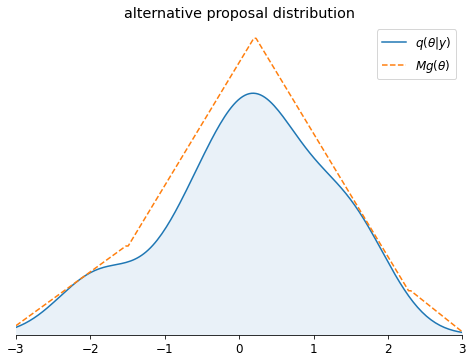

In [21]:
# alternative proposal distribution
g = np.empty(x.shape)
g[x <= -1.5] = np.linspace(q[0], np.max(q[x<=-1.5]), len(x[x<=-1.5]))
g[(x > -1.5) & (x <= 0.2)] = np.linspace(
    np.max(q[x<=-1.5]),
    np.max(q[(x>-1.5) & (x<=0.2)]),
    len(x[(x>-1.5) & (x<=0.2)])
)
g[(x > 0.2) & (x <= 2.3)] = np.linspace(
    np.max(q[(x>-1.5) & (x<=0.2)]),
    np.max(q[x>2.3]),
    len(x[(x>0.2) & (x<=2.3)])
)
g[x > 2.3] = np.linspace(np.max(q[x>2.3]), q[-1], len(x[x>2.3]))
M = np.max(q/g)
g *= M

# plot
plt.figure(figsize=(8, 6))
plot_tools.modify_axes.only_x(plt.gca())
plt.plot(x, q)
plt.plot(x, g, linestyle='--')
plt.fill_between(x, q, color=plot_tools.lighten('C0', 0.9))
plt.legend((r'$q(\theta|y)$', r'$Mg(\theta)$'))
plt.xlim([x[0], x[-1]])
plt.title('alternative proposal distribution');